In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.methods.lstm import *
from sketch2code.methods.baseline1_supervised import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#examples 1750


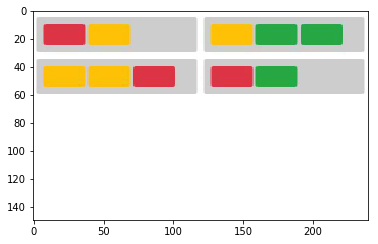

In [4]:
tags, images = load_dataset("toy")
print("#examples", len(tags))
images = [shrink_img(img, 0.5).transpose((2, 0, 1)) for img in norm_rgb_imgs(images[:])]
plt.imshow(1 - images[0].transpose(1, 2, 0))

In [5]:
_tokens = []
for c in ["row", "col-12", "col-6", "col-4", "col-3", "container-fluid", "grey-background"]:
    _tokens.append(f'<div class="{c}">')
_tokens.append(f"</div>")
for c in ["btn-danger", "btn-warning", "btn-success"]:
    _tokens.append(f'<button class="btn {c}">')
_tokens.append(f"</button>")

vocab = {'<pad>': 0}
for i, token in enumerate(_tokens, start=1):
    vocab[token] = i
    
assert len(vocab) == len(_tokens) + 1
ivocab = {v: k for k, v in vocab.items()}

In [6]:
def make_dataset(imgs, progs: List[int]):
    Ximgs = []
    X = []
    y = []
    
    for img, prog in zip(imgs, progs):
        for i in range(5, len(prog) - 1):
            Ximgs.append(img)
            X.append(prog[:i])
            y.append(prog[1:i+1])
    
    print(len(X))
    return Ximgs, X, y

def iter_batch(batch_size: int, imgs, X, y, shuffle: bool=False, device=None): 
    index = list(range(len(X)))
    if shuffle:
        np.random.shuffle(index)
        
    for i in range(0, len(X), batch_size):
        batch_idx = index[i:i+batch_size]
        bimgs = torch.tensor([imgs[j] for j in batch_idx], dtype=torch.float32, device=device)
        bx, by, bxlen = prepare_batch_sent_lbls([X[j] for j in batch_idx], [y[j] for j in batch_idx], device=device)
        yield (bimgs, bx, bxlen, by)

programs = []
for tag in tags:
    program = [vocab[x] for x in tag.linearize().str_tokens]
    programs.append(program)


train_imgs, train_X, train_y = make_dataset(images[:1250], programs[:1250])
valid_imgs, valid_X, valid_y = make_dataset(images[1250:1500], programs[1250:1500])
test_imgs, test_X, test_y = make_dataset(images[1500:], programs[1500:])

46402
10302
10210


In [7]:
model = BLSuper1(150, 240, vocab, dsl_embedding_dim=50, dsl_hidden_dim=100).to(device)

In [8]:
def eval(model, imgs, X, y, device=None):
    losses = []
    accuracies = []
    n_tokens = 0
    
    batch_size = 500
    model.eval()
    with torch.no_grad():
        for bimgs, bx, bxlen, by in tqdm(iter_batch(batch_size, imgs, X, y, device=device), desc='eval', total=math.ceil(len(X) / batch_size)):
            by_pred = model(bimgs, bx, bxlen)
            loss, mask, btokens = padded_aware_nllloss(by_pred, by)
            losses.append(loss.item())
            
            n_tokens += btokens
            accuracies.append(((torch.argmax(by_pred, dim=1) == by.view(-1)).float() * mask).sum().item())
            
    model.train()
    return np.mean(losses), sum(accuracies) / n_tokens

In [9]:
n_epoches = 2
batch_size = 100
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

histories = {'train': [], 'val': [], 'test': []}

for i in range(n_epoches):
    batches = tqdm(iter_batch(batch_size, train_imgs, train_X, train_y, shuffle=True, device=device), total=math.ceil(len(train_X) / batch_size))
    for bimgs, bx, bxlen, by in batches:
        model.zero_grad()
        by_pred = model(bimgs, bx, bxlen)
        loss, _, _ = padded_aware_nllloss(by_pred, by)
        histories['train'].append(loss)
        loss.backward()
        batches.set_description(f'train_loss = {loss:.5f}')
        batches.refresh()
        optimizer.step()
    
    vloss, vacc = eval(model, valid_imgs, valid_X, valid_y, device)
    print("Epoch", i, 'valid', f'loss={vloss:.5f}', f'acc={vacc:.5f}', flush=True)
    tloss, tacc = eval(model, test_imgs, test_X, test_y, device)
    print("Epoch", i, 'test', f'loss={tloss:.5f}', f'acc={tacc:.5f}', flush=True)
    histories['val'].append((vloss, vacc))
    histories['test'].append((tloss, tacc))

eval: 100%|██████████| 21/21 [01:24<00:00,  3.58s/it]

Epoch 0 valid loss=0.39128 acc=0.79626



eval: 100%|██████████| 21/21 [01:24<00:00,  3.40s/it]

Epoch 0 test loss=0.40100 acc=0.79316



eval: 100%|██████████| 21/21 [01:24<00:00,  3.61s/it]

Epoch 1 valid loss=0.39382 acc=0.79585



eval: 100%|██████████| 21/21 [01:23<00:00,  3.37s/it]

Epoch 1 test loss=0.40192 acc=0.79293


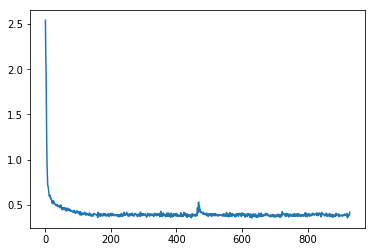

In [90]:
loss_train = [x.item() for x in histories['train']]
plt.plot(loss_train)

In [60]:
img = torch.tensor([test_imgs[0]], dtype=torch.float32, device=device)

In [61]:
img.shape

torch.Size([1, 3, 150, 240])

In [14]:
vocab

{'<pad>': 0,
 '<div class="row">': 1,
 '<div class="col-12">': 2,
 '<div class="col-6">': 3,
 '<div class="col-4">': 4,
 '<div class="col-3">': 5,
 '<div class="container-fluid">': 6,
 '<div class="grey-background">': 7,
 '</div>': 8,
 '<button class="btn btn-danger">': 9,
 '<button class="btn btn-warning">': 10,
 '<button class="btn btn-success">': 11,
 '</button>': 12}

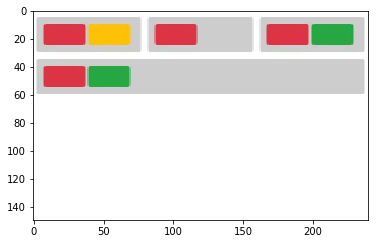

In [62]:
plt.imshow(1 - img[0].permute(1, 2, 0).cpu().numpy())

In [40]:
y_pred.shape

torch.Size([12, 13])

In [44]:
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), 480, 300)

In [79]:
def gen_program(img: torch.tensor):
    dsl_prog = LinearizedTag.default()
    program = [vocab['<div class="container-fluid">']]
    dsl_prog.add_tag_and_class('div', ('container-fluid',))

    for i in range(50):
        y_pred = model(torch.tensor([img], dtype=torch.float32, device=device), 
                       torch.tensor([program], dtype=torch.long, device=device), 
                       torch.tensor([len(program)], dtype=torch.long, device=device))
        next_token = torch.argmax(y_pred, dim=1)[-1].item()
        program.append(next_token)

        next_token = ivocab[next_token]
        if next_token.startswith("</"):
            # TODO: fix me
            dsl_prog.add_close_tag()
        else:
            match = LinearizedTag.tag_reg.match(next_token)
            dsl_prog.add_tag_and_class(match.group(1), tuple(match.group(2).split(" ")))

        if len(dsl_prog.opening_tags) == 0:
            break
        
    genimg = render_engine.render_page(dsl_prog)
    genimg = shrink_img(norm_rgb_imgs(genimg), 0.5)
    
    quality = (genimg == img.transpose((1, 2, 0))).sum() / np.prod(genimg.shape)
    return genimg, quality
#     plt.imshow(1 - genimg)

In [85]:
outputs = []

for img in tqdm(images[1500:]):
    gen_img, quality = gen_program(img)
    outputs.append((gen_img, quality))
# plt.imshow(1 - genimg)

100%|██████████| 250/250 [02:21<00:00,  1.69it/s]


quality 0.6670621481481481
best image 0.8134907407407408


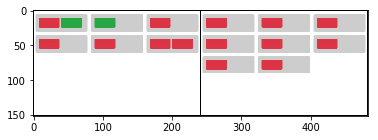

In [88]:
print('quality', np.mean([x[1] for x in outputs]))
idx, (genimg, quality) = max(enumerate(outputs), key=lambda x: x[1][1])
print('best image', quality)
a = viz_grid(np.stack([
    1 - images[1500:][idx].transpose((1, 2, 0)),
    1 - genimg
], axis=0))
plt.imshow(a)